In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

In [33]:
data = pd.read_csv("data/datahw1.csv")

In [34]:
data.head()

,x1,x2,x3,x4
0,0.000000,3.440000,0.440000,4.387545
1,0.040404,0.134949,0.888485,2.679650
2,0.080808,0.829899,1.336970,2.968490
3,0.121212,1.524848,1.785455,3.254065
4,0.161616,2.219798,2.233939,3.536375


## Task1-2

Фукнции запускаются на 3х переменных, но можно убрать лишние, чтобы обучить на каждой все т.к функции написаны для любого кол-ва перем. (опущено чтобы не перегружать)

Пример для каждой: (Далее все 3)

### a

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

for i in data.columns:
    if i != 'x4':
        x = pd.DataFrame(data[i])
        y = data['x4']
        lr = LinearRegression()
        lr.fit(x,y)
        print(f"{i} score: {mean_squared_error(lr.predict(x),y)}") 

x1 score: 1.9699861650978636
x2 score: 7.198732036355394
x3 score: 7.2589022492543345


### b

In [36]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

def cross(model, X, y):
    scoring = {'mse': make_scorer(mean_squared_error)}
    return cross_validate(model,X,y,scoring=scoring, cv=5)

In [37]:
crs = cross(LinearRegression(), data.drop('x4',axis=1), data['x4'])
print(crs["test_mse"])

[11.55835454  0.97973973  2.65880839  0.95970428 11.61723943]


In [38]:
data['x4'].describe()

count    100.000000
mean       1.851276
std        2.774643
min       -5.332455
25%        0.527533
50%        2.879003
75%        3.925389
max        5.545892
Name: x4, dtype: float64

Неплохая квадратичная ошибка, линейная регрессия имеет хорошую генерализацию в общем, но в данном случае видим промежутки из cv, где модель сравляется явно лучше.

### c

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import train_test_split

def poly(model,X,y):
    meta = []
    for deg in range(1,8):
        poly_features = PolynomialFeatures(degree=deg)
        X_poly = poly_features.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)
        mse, bias, var = bias_variance_decomp(
            model, X_train, y_train.values, X_test, y_test.values, loss='mse', num_rounds=100, random_seed=11
            )
        meta.append((deg, bias, var))
    return meta

In [40]:
def draw_bv(model,X,y):
    sub = poly(model, X,y)
    sns.lineplot(x=[i[0] for i in sub], y=[i[1] for i in sub],label="bias")
    sns.lineplot(x=[i[0] for i in sub], y=[i[2] for i in sub],label="var")
    plt.plot()

In [41]:
from sklearn.model_selection import KFold

def bias_variance_decomposition_cv(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    bias = []
    variance = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        m_pred = np.mean(pred)
        bias.append(np.mean((m_pred-y_test)**2))
        variance.append(np.var(pred))
    
    return np.mean(bias), np.mean(variance)

In [42]:
def poly_cv(model,X,y):
    meta = []
    for deg in range(1,8):
        poly_features = PolynomialFeatures(degree=deg)
        X_poly = poly_features.fit_transform(X)
        bias, var = bias_variance_decomposition_cv(model,X_poly,y,3)
        meta.append((deg, bias, var))
    return meta

In [43]:
def draw_bv_cv(model,X,y):
    sub = poly_cv(model, X,y)
    sns.lineplot(x=[i[0] for i in sub], y=[i[1] for i in sub],label="bias")
    sns.lineplot(x=[i[0] for i in sub], y=[i[2] for i in sub],label="var")
    plt.plot()

Библиотечный график

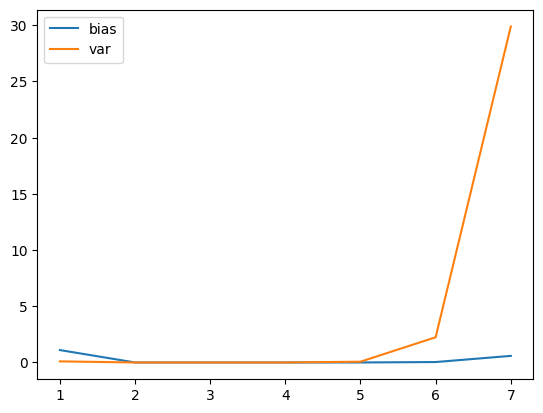

In [44]:
model = LinearRegression()
draw_bv(model, data.drop('x4',axis=1), data['x4'])

График на кросс валидации (kfold)

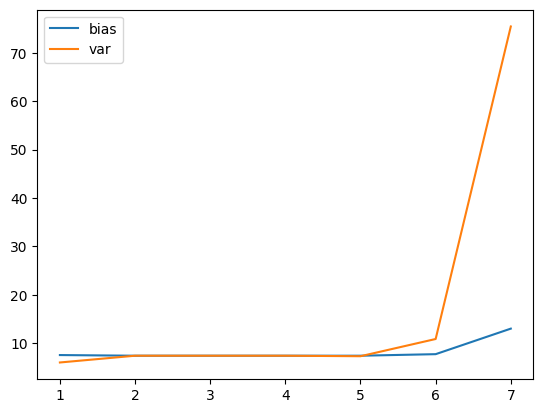

In [45]:
draw_bv_cv(model, data.drop('x4',axis=1), data['x4'])

Лучшая степень 2

### d

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

def kfld(X,y):
    X_fold, X_test, y_fold, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
    kfld = KFold(n_splits=5)
    score = 4214124
    degree = 0
    for deg in range(1,10):
        for i, (train_index, test_index) in enumerate(kfld.split(X_fold, y_fold)):
            model = LinearRegression()
            model.fit(PolynomialFeatures(degree).fit_transform(X_fold.iloc[train_index]), y_fold.iloc[train_index])
            scr = mean_squared_error(model.predict(PolynomialFeatures(degree).fit_transform(X_fold.iloc[test_index])), y_fold.iloc[test_index])
            if scr <= score:
                score = scr
                degree = deg
        print(f"degree: {deg} lowest_mse: {score} deg_mse: {scr}")

    model = LinearRegression()
    X_poly = PolynomialFeatures(degree).fit_transform(X_test)
    model.fit(X_poly, y_test)
    
    score = mean_squared_error(model.predict(X_poly), y_test)
    return (score, degree)

In [47]:
print(kfld(data.drop('x4',axis=1), data['x4'])," best deg")

degree: 1 lowest_mse: 1.4582272221610886 deg_mse: 1.6586362375718238
degree: 2 lowest_mse: 3.540277439714521e-29 deg_mse: 3.540277439714521e-29
degree: 3 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 4 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 5 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 6 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 7 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 8 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
degree: 9 lowest_mse: 1.5189094125974213e-29 deg_mse: 1.212160497432184e-28
(1.0003755193866919e-28, 3)  best deg


Лучшая 3я, но разницу не увидеть на графике

## Task3

In [48]:
def ker(x,mu,sig):
    return np.exp((-((x-mu)**2))/(2*(sig**2)))

In [49]:
target = data['x4']
data_tsk3 = data.drop('x4',axis=1)
data_tsk3.head()

,x1,x2,x3
0,0.000000,3.440000,0.440000
1,0.040404,0.134949,0.888485
2,0.080808,0.829899,1.336970
3,0.121212,1.524848,1.785455
4,0.161616,2.219798,2.233939


In [50]:
# преобразуем каждый набор x
for i in data_tsk3.columns:
    mu = np.random.uniform(-1,1,data_tsk3[i].shape)
    data_tsk3[i] = ker(data_tsk3[i], mu, abs(mu[len(mu)-1] - mu[int((len(mu)-1)/2)] ))

data_tsk3.head()

,x1,x2,x3
0,0.985596,0.129525,0.952398
1,0.919072,0.999069,0.870846
2,0.540577,0.999520,0.942832
3,0.868871,0.626799,0.594869
4,0.672335,0.755433,0.250116


In [51]:
lr = LinearRegression()
lr.fit(data_tsk3, target)

target_ped = lr.predict(data_tsk3)

crs = cross(lr, data_tsk3, target)
print(crs["test_mse"])

[ 2.84287371  4.77899899  6.71207166  0.79073748 24.39184622]


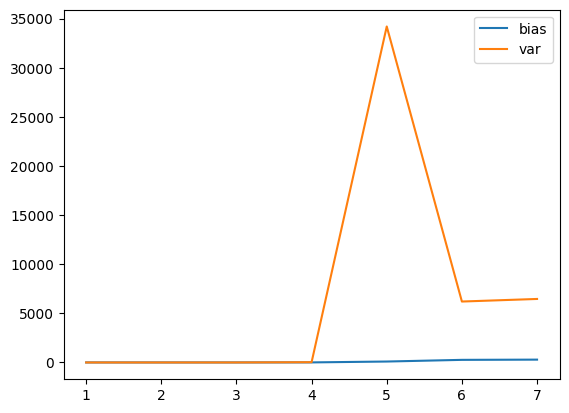

In [52]:
draw_bv(lr,data_tsk3,target)

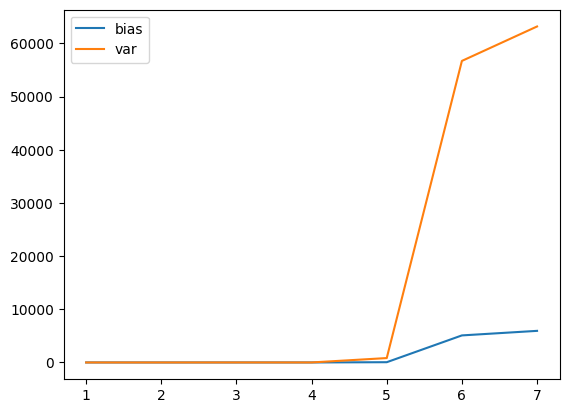

In [53]:
meta = draw_bv_cv(lr, data_tsk3, target)

In [54]:
kfld(data_tsk3, target)

degree: 1 lowest_mse: 1.0407809350115331 deg_mse: 1.0407809350115331
degree: 2 lowest_mse: 1.0407809350115331 deg_mse: 1.0407809350115331
degree: 3 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 4 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 5 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 6 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 7 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 8 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442
degree: 9 lowest_mse: 1.0407809350115331 deg_mse: 1.9873953399510442


(2.9397491073722883, 2)

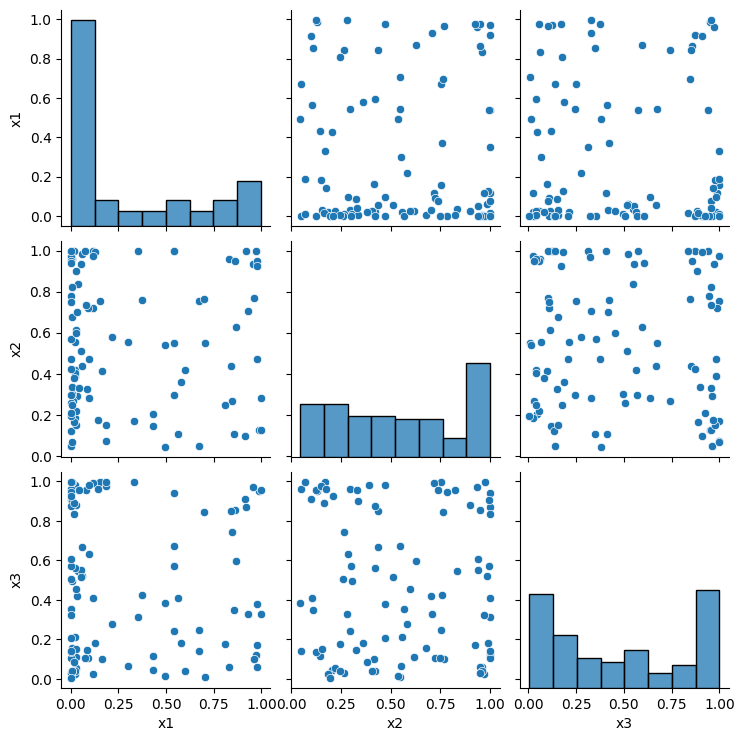

In [55]:
sns.pairplot(data = data_tsk3)

## Task 4

### a

Найдем функцию правдоподобия для распред Лапласса:
\begin{equation}
Laplace(\alpha,\mu) = \frac{\alpha}{2} e^{-\alpha |x-\mu|},
\end{equation}
где $\alpha = b^{-1},\;\mu = 0$\
LH:
\begin{equation}
LH = (\frac{\alpha}{2})^N exp \sum_{i=1}^{N}({-\alpha |y^{(i)}-\theta^T x^{(i)}|})
\end{equation}
Логорифмируем.\
И функция которую мы минимизируем получается:
\begin{equation}
\hat{\theta} =\text{argmin}_\theta \; |y^{(i)}-\theta^T x^{(i)}|
\end{equation}


### b

Данный поход лучше тем, что мы избегаем очень сильного вклада от больших значений случ величины, следовательно модель мение чувствительна к выбросам. Хуже тем, что модуль не дифф функиция, а следовательно нет аналитического решения через производную.

## Task 5

In [56]:
from sklearn.base import BaseEstimator

class LapRegression(BaseEstimator):
    def __init__(self, lr:float, num_iter:int) -> None:
        super().__init__()
        self.coef = None
        self.lr = lr
        self.num_iter = num_iter

    def fit(self, X, y) -> np.ndarray:
        loss = []
        if self.coef == None:
            self.coef = np.ones(X.shape[1])
        for i in range(self.num_iter):
            grad = self.__subgrad(X, y, 0.001)
            for o in range(len(self.coef)):
                self.coef[o] -= grad[o] * self.lr
            loss.append(self.__sae(y, self.__predict(X, theta=self.coef)))
        return np.array(loss)
    
    def predict(self, X:pd.DataFrame) -> np.ndarray:
        y_pred = []
        for i in range(len(X)):
            y_pred.append(np.dot(X.iloc[i], self.coef))         
        return np.array(y_pred)
    
    # отдельный предикт чтобы варировать тета
    def __predict(self, X:pd.DataFrame, theta) -> np.ndarray:
        y_pred = []
        for i in range(len(X)):
            y_pred.append(np.dot(X.iloc[i], theta))         
        return np.array(y_pred)
    
    # самая простая реализация производной через 1 точку
    def __subgrad(self, X, y_true, alpha) -> np.ndarray:
        grad = []
        theta = self.coef.copy()
        for i in range(len(theta)):
            theta_hat = theta.copy()
            theta_hat[i] += alpha 
            y = self.__predict(X, theta)
            y_hat = self.__predict(X, theta_hat)
            grad.append((self.__sae(y_true, y_hat) - self.__sae(y_true, y))/alpha)
        return np.array(grad)
    
    # суммарная ошибка
    def __sae(self, y_true, y_pred):
        return np.sum(np.abs(y_true-y_pred))
    

In [57]:
data.head()

,x1,x2,x3,x4
0,0.000000,3.440000,0.440000,4.387545
1,0.040404,0.134949,0.888485,2.679650
2,0.080808,0.829899,1.336970,2.968490
3,0.121212,1.524848,1.785455,3.254065
4,0.161616,2.219798,2.233939,3.536375


In [58]:
lapreg = LapRegression(lr=0.001, num_iter=100)
loss = lapreg.fit(data.drop('x4',axis=1), target)


<Axes: >

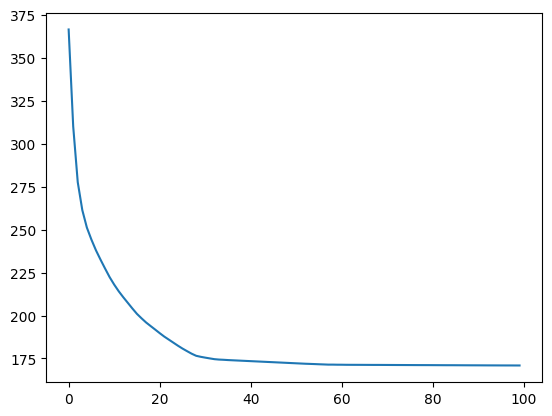

In [59]:
sns.lineplot(x = np.arange(0,len(loss),1),y=loss)

In [60]:
y_pred = lapreg.predict(data.drop('x4',axis=1))

In [61]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(target, y_pred))

1.7092991326833402


In [62]:
cv = cross_validate(lapreg,data.drop('x4',axis=1),target,cv=10,scoring="neg_mean_absolute_error")
print(-cv["test_score"])

[1.39577213 1.21740652 1.78690022 2.27271576 2.09308093 1.88190811
 1.17407382 1.3374075  2.28692553 3.99151234]
